# Characterizing the microscopic structure: The pair correlation function

Ralf Everaers, ENS Lyon (2022)

According to Wikipedia [https://en.wikipedia.org/wiki/Radial_distribution_function]:
    
"In statistical mechanics, the radial distribution function, (or pair correlation function) $g(r)$ in a system of particles (atoms, molecules, colloids, etc.), describes how density varies as a function of distance from a reference particle.

If a given particle is taken to be at the origin O, and if $\rho = N / V $ is the average number density of particles, then the local time-averaged density at a distance $r$ from O is $\rho g(r)$ ... \[in\] a homogeneous and isotropic system. 

In simplest terms it is a measure of the probability of finding a particle at a distance of $r$ away from a given reference particle, relative to that for an ideal gas. The general algorithm involves determining how many particles are within a distance of $r$ and $r + d r$ away from a particle. This general theme is depicted \[below\], where the red particle is our reference particle, and blue particles are those whose centers are within the circular shell, dotted in orange. "

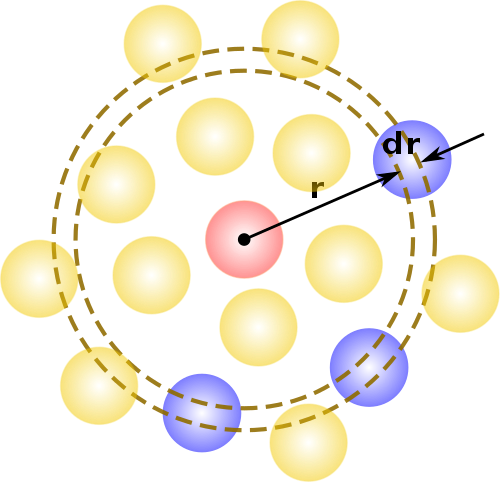

In [1]:
# Import standard libraries
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

## The routine

We need the surface of the hypersphere

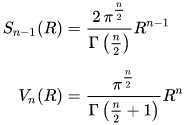

In [2]:
def UnitHyperSphereSurface(d): return 2.*np.pi**(d/2.)/gamma(d/2.)
def UnitHyperSphereVolume(d): return np.pi**(d/2.)/gamma(d/2.+1)

In [3]:
for d in range (4): print(d,UnitHyperSphereSurface(d),UnitHyperSphereVolume(d))

0 0.0 1.0
1 2.0 2.0
2 6.283185307179586 3.141592653589793
3 12.566370614359174 4.188790204786391


In [4]:
def Radial_distribution_function(d,LBox,pos,r_range=(0.0,5.0),bins=50,debug=False):
    """
    returns the pair correlation function as a function of the positions of all particles
    """
    r = np.array(pos)
    
    if r.ndim>d:
        # data for a trajectory or an ensemble of trajectories
        NParticles = r.shape[-1]
        NDataSets = r.size//d//NParticles
        
    elif r.ndim==d:
        # data for an individual snapshot        
        NParticles = r.shape[-1]
        NDataSets = 1

    else:
        print("provided coordinates are dimension ",r.ndim)
        print("expected dimension ",d)
        return
        
    rho = (NParticles-1)/LBox**2
    # this is the density of all the OTHER particles, which a test particle can see
        
    if debug:
        print(NParticles, "particles in one configuration")
        print(NDataSets, "data sets")
        print("r_range",r_range)
        print("bins",bins)
    
    hist = np.zeros(bins)
    
    for k in range(1,NParticles):
        delta_r_pair_vectors = MD.MinimumImage(LBox,r-np.roll(r,k,axis=-1))
        delta_r_pair_sqr = delta_r_pair_vectors**2              # array of Cartesian components of squared distances
        if d > 1:
            delta_r_pair_sqr = np.sum(delta_r_pair_sqr,axis=0)         # add up Cartesian components in d>1
        delta_r_pair = np.sqrt(delta_r_pair_sqr)
        hist_k, bin_edges = np.histogram(delta_r_pair, bins, r_range, normed=None, weights=None, density=None)
        hist += hist_k
        
    if debug:
        print(np.sum(hist)," pair distances")
        print(NParticles*(NParticles-1)*NDataSets," expected")

    # expected number of pair distances in spherical shell
    normalization = (UnitHyperSphereSurface(d)*MD.BinCenters(bin_edges)**(d-1)*(r_range[1]-r_range[0])/bins*
                     # bin volume
                     rho*
                     # density
                     NDataSets*NParticles
                     # number of test particles = number of datasets * number of particles
                    )
        
    if debug:
        print(np.sum(normalization),"expected pair distances in an ideal gas")

    return hist/normalization, bin_edges

## The structure of an ideal gas

Now test this for an ideal gas "trajectory". 

The r_range is chosen comparable to half the box size. Not that we miss some distances between particles located in the corners of the cubic simulation box centered on the test particle.

In [5]:
# define system
NParticles=256
kT = 1
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.5/sigma**3
LBox = np.power(NParticles/rho,1/2)
print("LBox = ",LBox)

# number of "time steps"
NSteps = 100

x_tr = []
y_tr = []

# define initial state
for n in range(NSteps):
    x_tr.append(MD.RandomPositions(LBox,NParticles))
    y_tr.append(MD.RandomPositions(LBox,NParticles))

x_tr = np.array(x_tr)
y_tr = np.array(y_tr)

g, r_bin_edges = Radial_distribution_function(2,LBox,(x_tr,y_tr),r_range=(0,12),bins=120,debug=True)

LBox =  22.627416997969522
256 particles in one configuration
100 data sets
r_range (0, 12)
bins 120
5578676.0  pair distances
6528000  expected
5767964.11199086 expected pair distances in an ideal gas


Text(0, 0.5, 'g(r)')

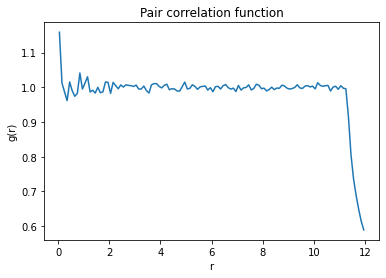

In [6]:
plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

The pair correlation function reveals, that there is no structure.

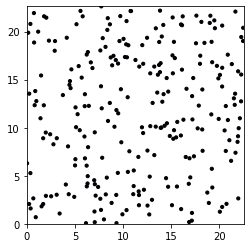

In [7]:
MD.PlotMDConf(x_tr[-1],y_tr[-1],xBox=(0,LBox),yBox=(0,LBox),xpbc=True,ypbc=True,m=m)

## The structure of a T=0 crystalline solid

As an example for a crystalline solid we can choose the grid configurations we designed as initial states.

In [8]:
# define system
NParticles=256
kT = 1
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.5/sigma**3
LBox = np.power(NParticles/rho,1/2)
print("LBox = ",LBox)

# number of "time steps"
NSteps = 100

x_tr = []
y_tr = []

# define initial state
for n in range(NSteps):
    x,y = MD.GridPositionsIn2d(LBox,LBox,NParticles)
    x_tr.append(x)
    y_tr.append(y)

x_tr = np.array(x_tr)
y_tr = np.array(y_tr)

g, r_bin_edges = Radial_distribution_function(2,LBox,(x_tr,y_tr),r_range=(0.5,12.5),bins=500,debug=True)

LBox =  22.627416997969522
256 particles in one configuration
100 data sets
r_range (0.5, 12.5)
bins 500
5785600.0  pair distances
6528000  expected
6248627.787990098 expected pair distances in an ideal gas


Text(0, 0.5, 'g(r)')

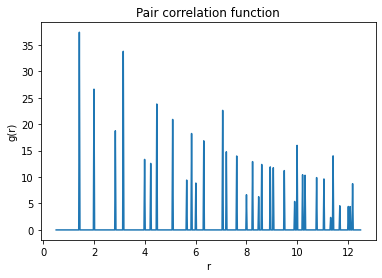

In [9]:
plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

There are discrete peaks corresponding to the possible distances between lattice sites.

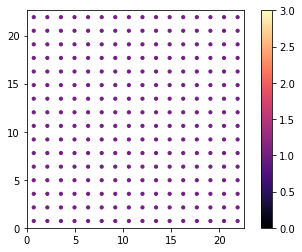

In [10]:
MD.PlotMDConf(x_tr[-1],y_tr[-1],xBox=(0,LBox),yBox=(0,LBox),xpbc=True,ypbc=True,m=m,c=m)

## The structure of a liquid

To test this for a liquid, we actually need to run a little simulation!

In [11]:
# define system
d=2
NParticles=256
kT = 1
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.7/sigma**d
LBox = np.power(NParticles/rho,1/2)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 10 * tau
delta_t = tau / 100
number_of_timesteps = int(np.round(run_time/delta_t))


# to measure the computer time needed to calculate the ensemble of trajectory
initialWallTime = time.perf_counter()

# define initial state
x,y = MD.GridPositionsIn2d(LBox,LBox,NParticles)
vx = MD.RandomVelocities(m,kT)
vy = MD.RandomVelocities(m,kT)
t = 0

fx,fy = MD.LJ_forces_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
uPot = MD.LJ_energies_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
P = MD.LJ_virial_pressure_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y)) + MD.KineticPressure_as_a_function_of_velocities(2,LBox,m,(vx,vy))

#initialize Trajectory
t_tr = [t]
x_tr = [x]
vx_tr = [vx]
y_tr = [y]
vy_tr = [vy]
uPot_tr = [uPot]
P_tr = [P]

for timestep in range(number_of_timesteps):
    (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartOne(m,(x,y),(vx,vy),(fx,fy),delta_t)
    fx,fy = MD.LJ_forces_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
    (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartTwo(m,(x,y),(vx,vy),(fx,fy),delta_t)
    t += delta_t
    uPot = MD.LJ_energies_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
    P = MD.LJ_virial_pressure_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y)) + MD.KineticPressure_as_a_function_of_velocities(2,LBox,m,(vx,vy))

    t_tr.append(t)
    x_tr.append(x)
    vx_tr.append(vx)
    y_tr.append(y)
    vy_tr.append(vy)
    uPot_tr.append(uPot)   # do this at each time step, since routine is not (yet) suitable for analysing entire trajectories
    P_tr.append(P)
    
# convert trajectory lists to arrays to simplify the data analysis
t_tr = np.array(t_tr)
x_tr = np.array(x_tr)
vx_tr = np.array(vx_tr)
y_tr = np.array(y_tr)
vy_tr = np.array(vy_tr)
uPot_tr = np.array(uPot_tr)
P_tr = np.array(P_tr)

# analyse results 
uKin_tr = MD.ParticleKineticEnergies(m,vx_tr) + MD.ParticleKineticEnergies(m,vy_tr)
u_tr = np.sum(uKin_tr,axis=-1) + np.sum(uPot_tr,axis=-1)/2
        
print("Execution time: ",time.perf_counter() - initialWallTime)

LBox =  19.123657749350297
Execution time:  69.98960304799994


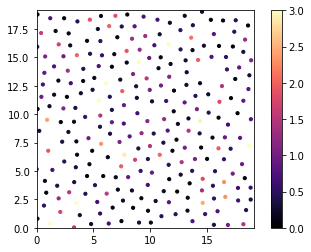

In [12]:
MD.PlotMDConf(x_tr[-1],y_tr[-1],xBox=(0,LBox),yBox=(0,LBox),xpbc=True,ypbc=True,m=m,c=uKin_tr[-1])

In [13]:
g, r_bin_edges = Radial_distribution_function(2,LBox,(x_tr,y_tr),r_range=(0,12),bins=120,debug=True)

256 particles in one configuration
1001 data sets
r_range (0, 12)
bins 120
63611996.0  pair distances
65345280  expected
80832249.06543994 expected pair distances in an ideal gas


Text(0, 0.5, 'g(r)')

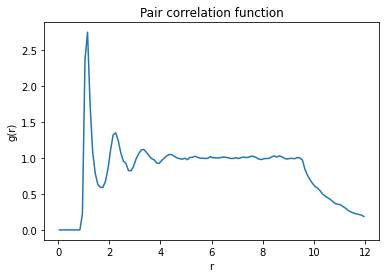

In [14]:
plt.plot(MD.BinCenters(r_bin_edges),g)
plt.title("Pair correlation function")
plt.xlabel("r")
plt.ylabel("g(r)")

There is LOCAL structure with discernable first and second nearest neighbor shells.

Text(0, 0.5, 'N(r)')

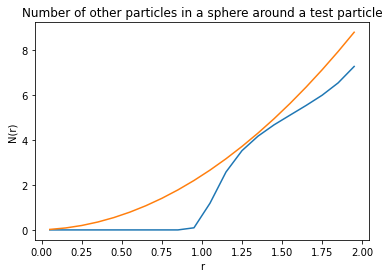

In [15]:
last_bin = 20
number_of_neighbors_up_to_a_distance = np.cumsum(g*rho*MD.UnitHyperSphereSurface(d)*MD.BinCenters(r_bin_edges)**(d-1)*(r_bin_edges[1]-r_bin_edges[0]))
ideal_number_of_neighbors_up_to_a_distance = np.cumsum(rho*MD.UnitHyperSphereSurface(d)*MD.BinCenters(r_bin_edges)**(d-1)*(r_bin_edges[1]-r_bin_edges[0]))
plt.plot(MD.BinCenters(r_bin_edges)[:last_bin],number_of_neighbors_up_to_a_distance[:last_bin])
plt.plot(MD.BinCenters(r_bin_edges)[:last_bin],ideal_number_of_neighbors_up_to_a_distance[:last_bin])
plt.title("Number of other particles in a sphere around a test particle")
plt.xlabel("r")
plt.ylabel("N(r)")

But are the data reasonably equilibrated? We also need to analyze the dynamics of our systems!

## Defining a local order parameter 

Calculate for each particle the number of nearest neighbors found within a suitable radius around the particle.

In [25]:
def Number_of_nearest_neighbors(d,LBox,pos,r_max,debug=False):
    """
    returns for each particle and each snapshot the number of other particles found within a radius of r_max
    """
    r = np.array(pos)
    
    if r.ndim>d:
        # data for a trajectory or an ensemble of trajectories
        NParticles = r.shape[-1]
        NDataSets = r.size//d//NParticles
        
    elif r.ndim==d:
        # data for an individual snapshot        
        NParticles = r.shape[-1]
        NDataSets = 1

    else:
        print("provided coordinates are dimension ",r.ndim)
        print("expected dimension ",d)
        return
    
    if d==1:
        # output has the same format as 1d position information: 
        # instead of a float indicating a particle position we now have an integer indicating the number of close-by neighbors
        NNN = 0*np.copy(r).astype(int)
    else:
        # output has the same format as 1d position information: 
        # instead of a float indicating a particle position we now have an integer indicating the number of close-by neighbors
        NNN = 0*np.copy(r[0]).astype(int)
                
    if debug:
        print(NParticles, "particles in one configuration")
        print(NDataSets, "data sets")
        print("r_max",r_max)
    
    for k in range(1,NParticles):
        delta_r_pair_vectors = MD.MinimumImage(LBox,r-np.roll(r,k,axis=-1))
        delta_r_pair_sqr = delta_r_pair_vectors**2              # array of Cartesian components of squared distances
        if d > 1:
            delta_r_pair_sqr = np.sum(delta_r_pair_sqr,axis=0)         # add up Cartesian components in d>1

        pair_in_range = np.round((np.sign(r_max**2-delta_r_pair_sqr)+1.0)/2.0).astype(int)
        
        NNN += pair_in_range

    return NNN

Test for initial grid conformation:

Calculate grid constant

In [26]:
x_tr[0,0]-x_tr[0,1]

-1.1952286093343933

In [27]:
y_tr[0,0]-y_tr[0,1]

0.0

and distance to next nearest neighbors:

In [28]:
1.1952286093343933*np.sqrt(2.0)

1.690308509457033

In [29]:
Number_of_nearest_neighbors(2,LBox,(x_tr[0],y_tr[0]),1.5,debug=True)

256 particles in one configuration
1 data sets
r_max 1.5


array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [30]:
Number_of_nearest_neighbors(2,LBox,(x_tr[0],y_tr[0]),2,debug=True)

256 particles in one configuration
1 data sets
r_max 2


array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

Make a histogram from data for the entire trajectory

In [31]:
nnn_hist, nnn_bin_edges = np.histogram(Number_of_nearest_neighbors(2,LBox,(x_tr,y_tr),2), 20, (0,20),normed=None, weights=None, density=None)

Text(0, 0.5, 'p(n)')

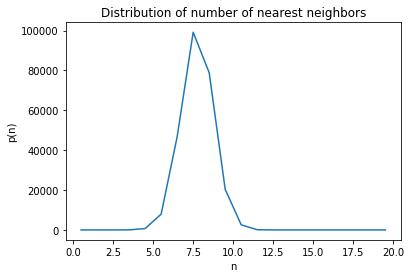

In [23]:
plt.plot(MD.BinCenters(nnn_bin_edges),nnn_hist)
plt.title("Distribution of number of nearest neighbors")
plt.xlabel("n")
plt.ylabel("p(n)")

Compare the mean value to our previous result for the integrated g(r) above!

In [24]:
np.mean(Number_of_nearest_neighbors(2,LBox,(x_tr,y_tr),2))

7.24526254995005